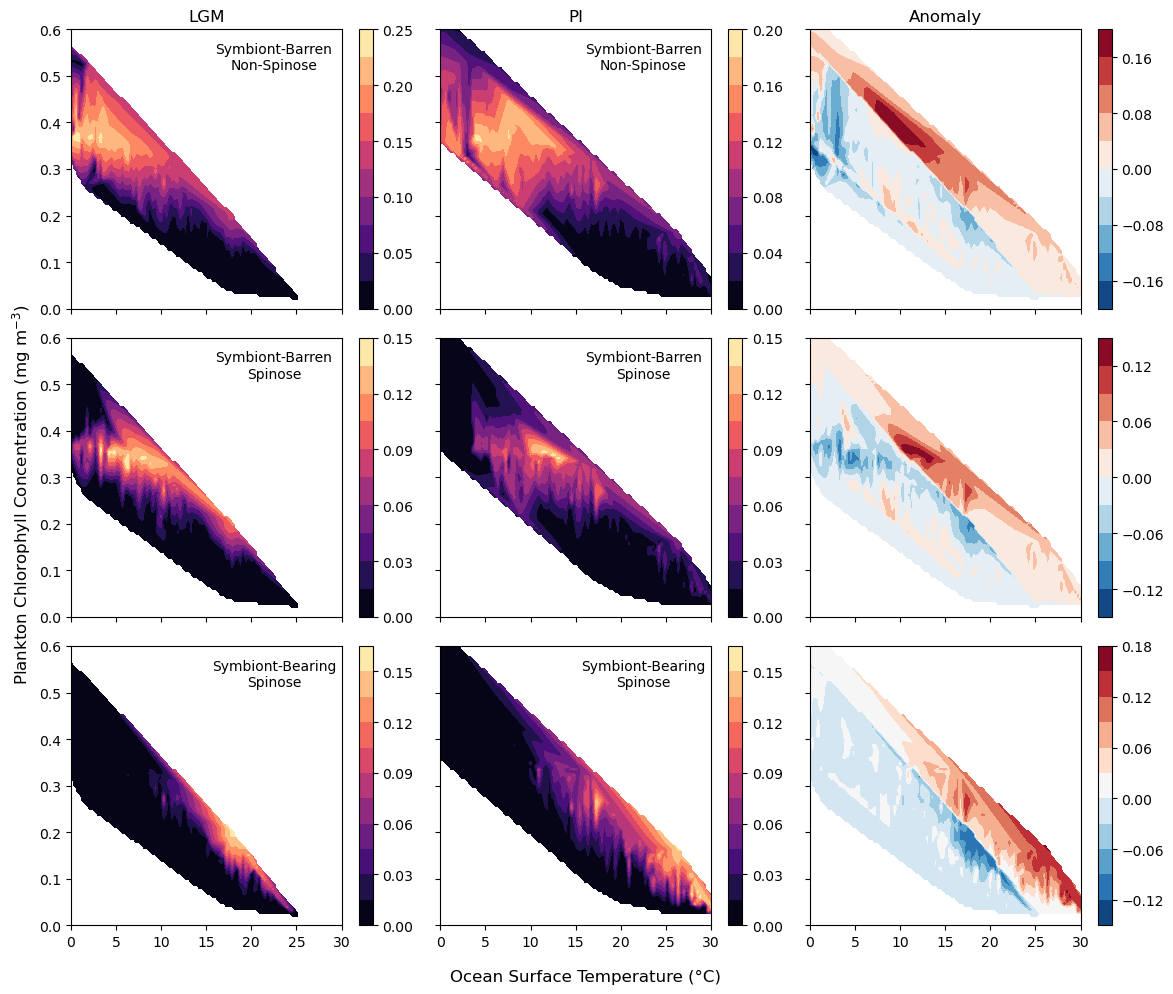

In [ ]:
from cgeniepy.foram import ForamModel
from scipy.interpolate import griddata
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import numpy as np

def build_2D_contourf(mod, foram):
    z = mod.select_foramtype(foram).biomass().isel(time=-1).pure_array().flatten()
    x = mod.select_var("ocn_sur_temp").isel(time=-1).pure_array().flatten()
    y = mod.select_var("eco2D_Plankton_Chl_Total").isel(time=-1).pure_array().flatten()
    ## drop nan
    z = z[~np.isnan(z)]
    x = x[~np.isnan(x)]
    y = y[~np.isnan(y)]
    xi = np.linspace(0, 30, 100)
    yi = np.linspace(0,0.65, 100)
    X,Y = np.meshgrid(xi,yi)
    Z = griddata((x,y),z,(X,Y), method='linear')
    ## show only the optimal values of Z
    Z[Z<0.3*Z] = np.nan

    return xi, yi, Z

def cal_anomaly(a, b):
    """
    Simple 2D anomaly calculation, a - b.
    If one value is NaN and the other is not, replace the NaN value with 0 before performing subtraction.
    """
    a_copy = a.copy()
    b_copy = b.copy()

    a_copy[np.isnan(a) & ~np.isnan(b)] = 0
    b_copy[np.isnan(b) & ~np.isnan(a)] = 0
    diff = a_copy - b_copy

    return diff
    
mod_list = [
        ForamModel("/Users/yingrui/Science/lgm_foram_niche/model/muffin.CBE.GIteiiva.BASESFeTDTL_rb.SPIN/"),
        ForamModel("/Users/yingrui/Science/lgm_foram_niche/model/muffin.CBE.worlg4.BASESFeTDTL.SPIN")
    ]

foramtype = ["bn", "bs", "ss"]
foramtype_names = {
    "bn": "Symbiont-Barren\nNon-Spinose",
    "bs": "Symbiont-Barren\nSpinose",
    "ss": "Symbiont-Bearing\nSpinose"
}
# Calculate biomass data for all foram types and models

data_dict = {}
for foram in foramtype:
    data_dict[foram] = {}
    for mod in mod_list:
        xi, yi, Z = build_2D_contourf(mod, foram)
        data_dict[foram][str(mod)] = {'xi': xi, 'yi': yi, 'Z': Z}
        
# Create a 3x3 grid of plots using matplotlib
fig, axs = plt.subplots(nrows=3, ncols=3, figsize=(12, 10), sharex=True, sharey=True)
fig.supxlabel("Ocean Surface Temperature (°C)")
fig.supylabel(r"Plankton Chlorophyll Concentration (mg m$^{-3}$)")

contour_levels = 10
for i, foram in enumerate(foramtype, 0):
    for j, mod in enumerate(mod_list, 0):
        data = data_dict[foram][str(mod)]
        cs = axs[i, j].contourf(data['xi'], data['yi'], data['Z'], levels=contour_levels, cmap='magma')
        axs[i, j].set_xlim([0, 30])
        axs[i, j].set_ylim([0, 0.6])
        fig.colorbar(cs, ax=axs[i, j], label="")
        ## add foram name in right corner
        axs[i, j].text(0.75, 0.9, foramtype_names[foram], horizontalalignment='center', verticalalignment='center', transform=axs[i, j].transAxes)

    # Calculate and add the anomaly subplot
    data_prev = data_dict[foram][str(mod_list[0])]
    anomaly = cal_anomaly(data['Z'], data_prev['Z'])
    cs_anomaly = axs[i, 2].contourf(data['xi'], data['yi'], anomaly, levels=contour_levels, cmap='RdBu_r')
    axs[i, 2].set_xlim([0, 30])
    axs[i, 2].set_ylim([0, 0.6])
    fig.colorbar(cs_anomaly, ax=axs[i, 2], label="")

## add title for each column
axs[0, 0].set_title("LGM")
axs[0, 1].set_title("PI")
axs[0, 2].set_title("Anomaly")

# Adjust the layout to prevent overlapping of subplots
plt.tight_layout()

# Show the figure
plt.show()

## save the figure
fig.savefig("../output//niche_space.png", dpi=300)